In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 340

ng =10

ng_refs = (/ 3 , 2 , 5 /) 

nref =3

nv = 200

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =300

vstar = 0

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66/

data wgt
     &     /0.3 , 0.3 , 0.3 , 0.3,
     &     0.3 , 0.3 , 0.6 , 0.6,
     &     0.6 , 0.6/

atmosphere_profiles/trp75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

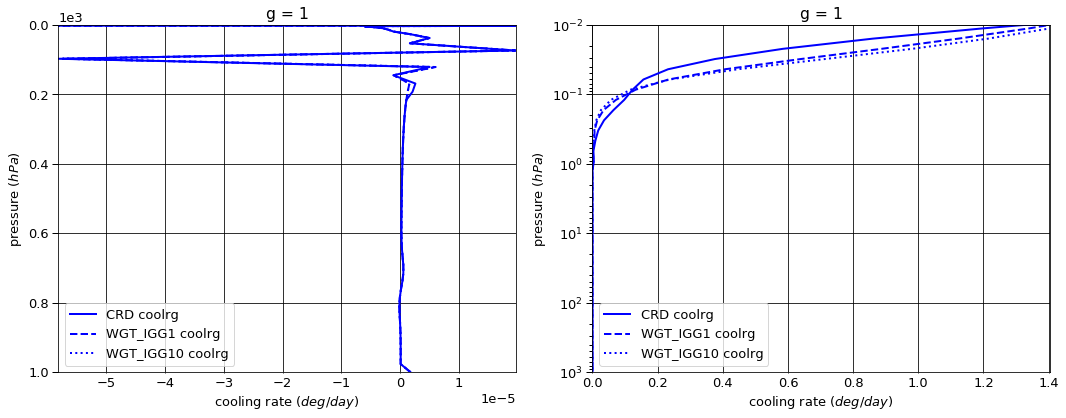

# Figure: cooling rate g-group 2

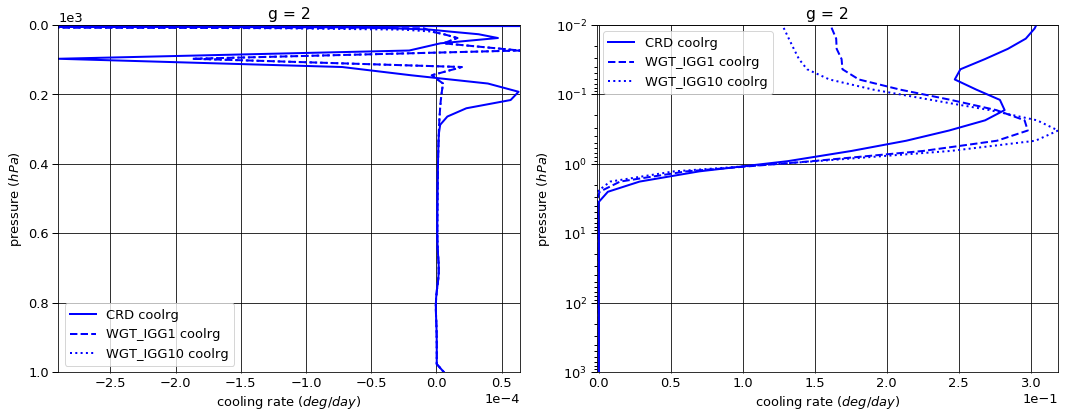

# Figure: cooling rate g-group 3

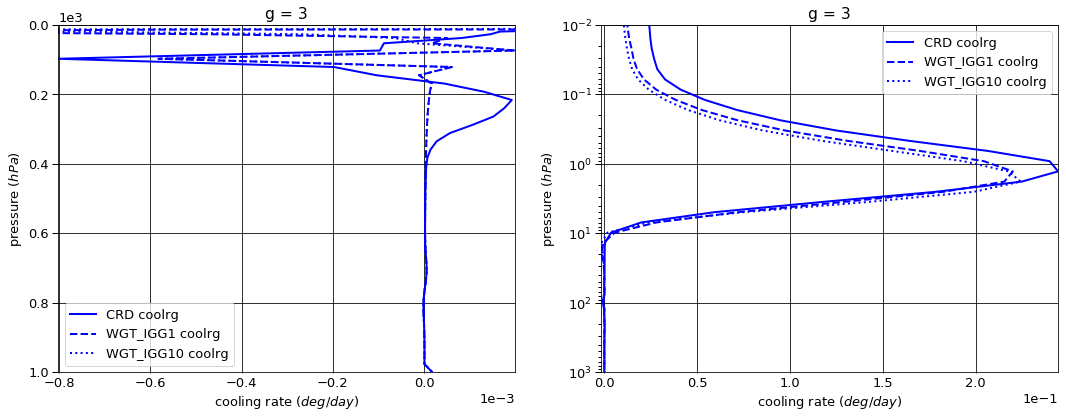

# Figure: cooling rate g-group 4

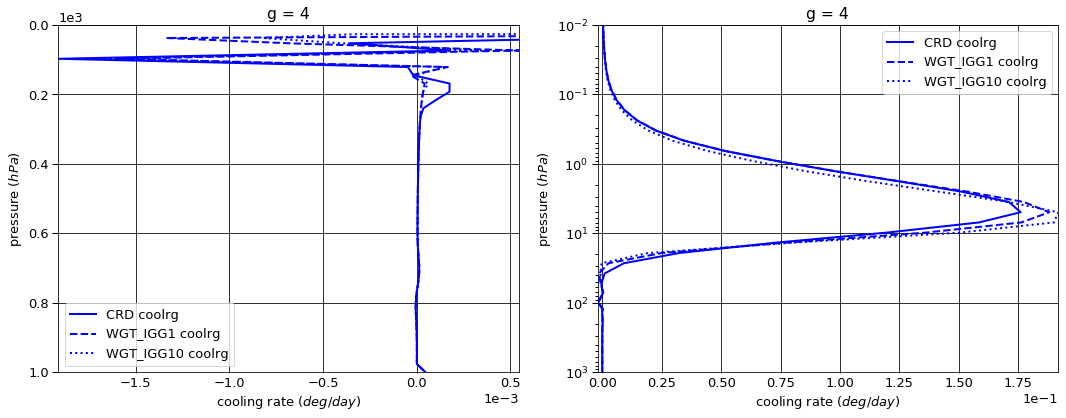

# Figure: cooling rate g-group 5

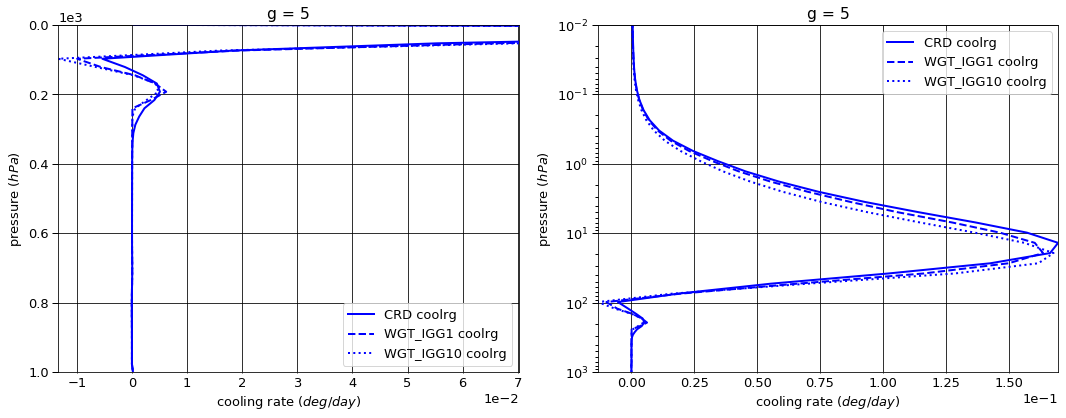

# Figure: cooling rate g-group 6

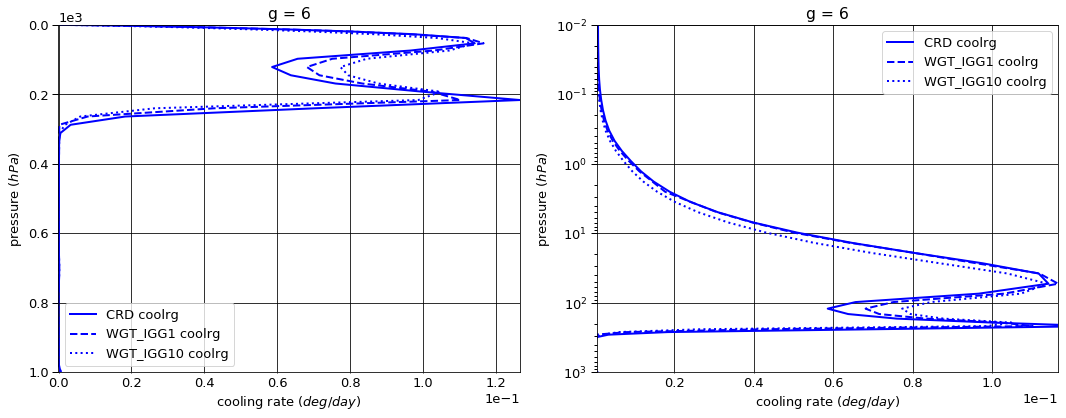

# Figure: cooling rate g-group 7

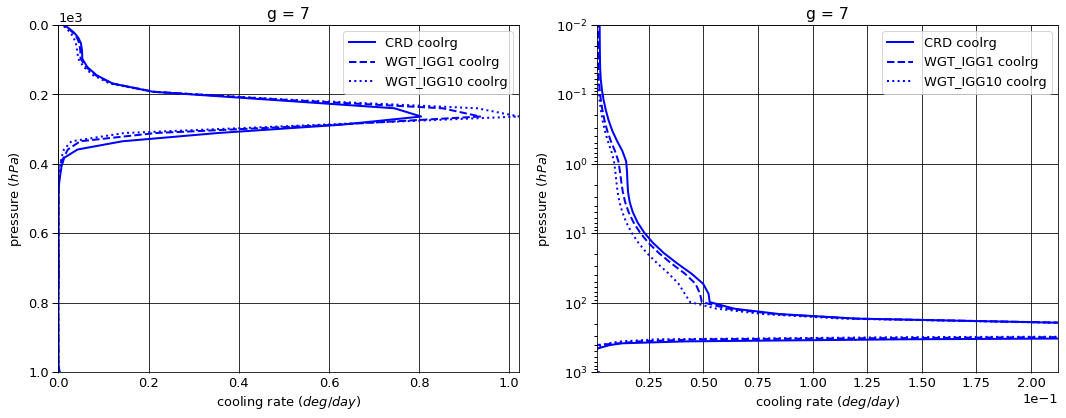

# Figure: cooling rate g-group 8

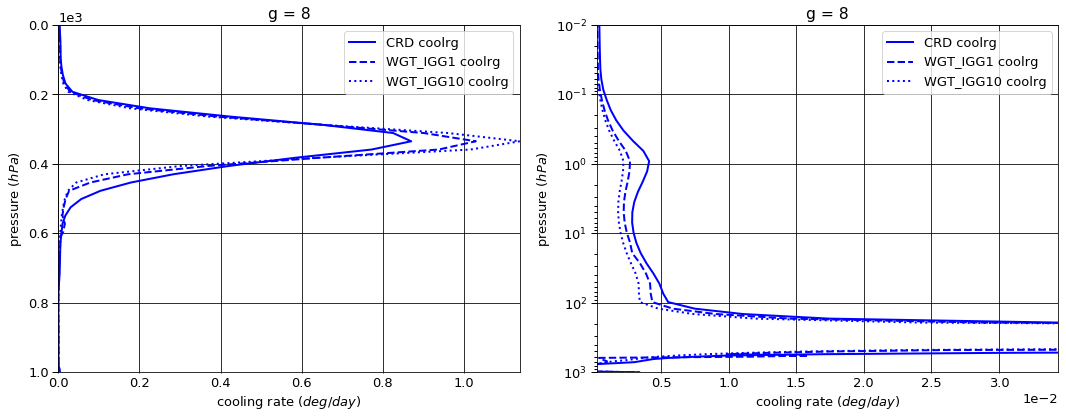

# Figure: cooling rate g-group 9

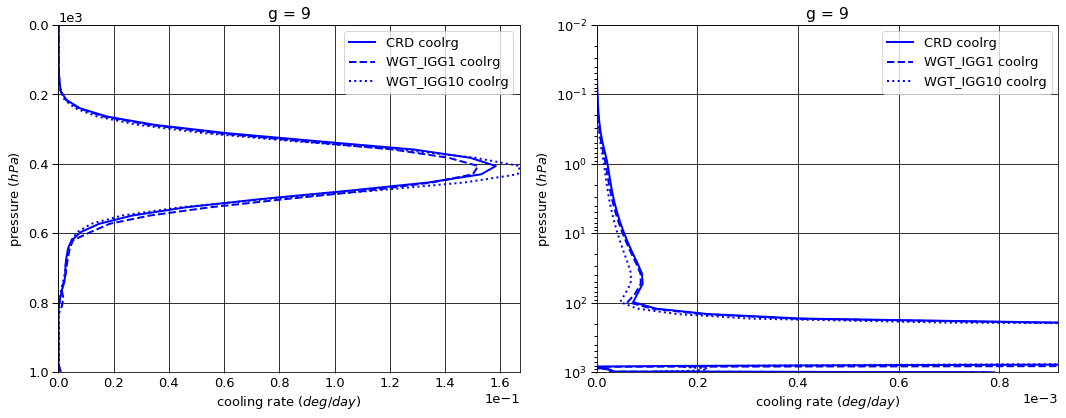

# Figure: cooling rate g-group 10

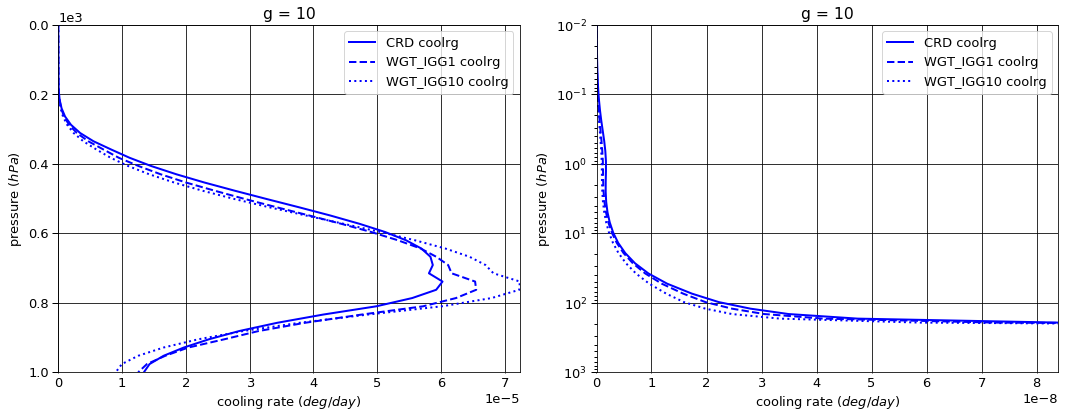

# Figure: cooling rate g-group total

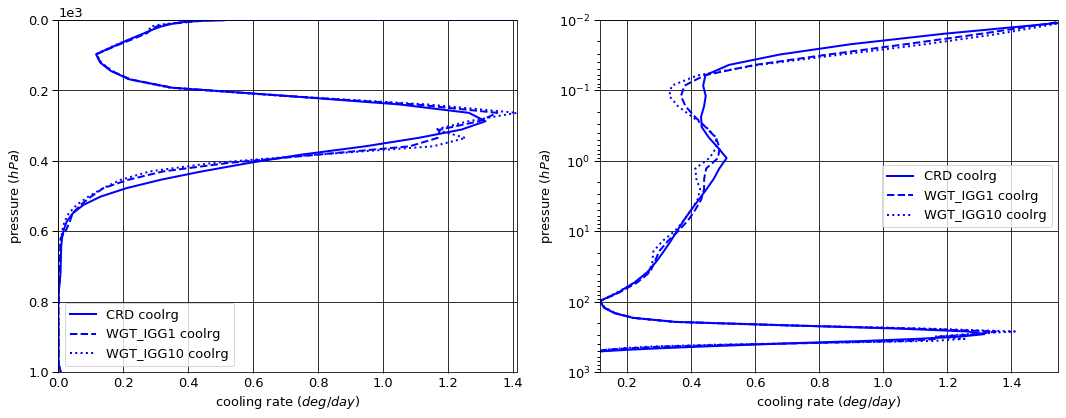

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007676   0.000000  -0.007676
   1013.0   76     -0.013241   0.013236  -0.000005
2  0.0      1      -0.031103   0.000000  -0.031103
   1013.0   76     -0.042775   0.042759  -0.000016
3  0.0      1      -0.102089   0.000000  -0.102089
   1013.0   76     -0.134024   0.133975  -0.000050
4  0.0      1      -0.254918   0.000000  -0.254918
   1013.0   76     -0.371237   0.371102  -0.000134
5  0.0      1      -0.887597   0.000000  -0.887597
   1013.0   76     -1.509415   1.508865  -0.000550
6  0.0      1      -2.578229   0.000000  -2.578229
   1013.0   76     -4.677316   4.675622  -0.001694
7  0.0      1     -11.007922   0.000000 -11.007922
   1013.0   76    -17.650366  17.643908  -0.006458
8  0.0      1     -15.987006   0.000000 -15.987006
   1013.0   76    -23.537262  23.527904  -0.009358
9  0.0      1      -3.489721   0.000000  -3.489721
   1013.0   76     -4.945552   4.943370  -0.002182
10 0.0      1      -0.003020   0.000000  -0.003020
   1013.0   76     -0.003256   0.003140  -0.000116


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007563   0.000000  -0.007563
   1013.0   76     -0.013241   0.013236  -0.000005
2  0.0      1      -0.031693   0.000000  -0.031693
   1013.0   76     -0.042775   0.042759  -0.000016
3  0.0      1      -0.101977   0.000000  -0.101977
   1013.0   76     -0.134024   0.133975  -0.000050
4  0.0      1      -0.256997   0.000000  -0.256997
   1013.0   76     -0.371237   0.371102  -0.000134
5  0.0      1      -0.883190   0.000000  -0.883190
   1013.0   76     -1.509415   1.508865  -0.000550
6  0.0      1      -2.539735   0.000000  -2.539735
   1013.0   76     -4.677316   4.675622  -0.001694
7  0.0      1     -10.925826   0.000000 -10.925826
   1013.0   76    -17.650366  17.643908  -0.006458
8  0.0      1     -15.871569   0.000000 -15.871569
   1013.0   76    -23.537262  23.527904  -0.009358
9  0.0      1      -3.506575   0.000000  -3.506575
   1013.0   76     -4.945552   4.943385  -0.002167
10 0.0      1      -0.003027   0.000000  -0.003027
   1013.0   76     -0.003256   0.003177  -0.000079


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007536   0.000000  -0.007536
   1013.0   76     -0.013241   0.013236  -0.000005
2  0.0      1      -0.031773   0.000000  -0.031773
   1013.0   76     -0.042775   0.042759  -0.000016
3  0.0      1      -0.102315   0.000000  -0.102315
   1013.0   76     -0.134024   0.133975  -0.000050
4  0.0      1      -0.257140   0.000000  -0.257140
   1013.0   76     -0.371237   0.371102  -0.000134
5  0.0      1      -0.883889   0.000000  -0.883889
   1013.0   76     -1.509415   1.508865  -0.000550
6  0.0      1      -2.518438   0.000000  -2.518438
   1013.0   76     -4.677316   4.675622  -0.001694
7  0.0      1     -10.927948   0.000000 -10.927948
   1013.0   76    -17.650366  17.643908  -0.006458
8  0.0      1     -15.863937   0.000000 -15.863937
   1013.0   76    -23.537262  23.527904  -0.009358
9  0.0      1      -3.502266   0.000000  -3.502266
   1013.0   76     -4.945552   4.943385  -0.002167
10 0.0      1      -0.003027   0.000000  -0.003027
   1013.0   76     -0.003256   0.003210  -0.000046


WGT_IGG1 - CRD


flug      fldg         fnetg
g  pressure level                                      
1  0.0      1      1.128723e-04  0.000000  1.128723e-04
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
2  0.0      1     -5.904300e-04  0.000000 -5.904300e-04
   1013.0   76     6.938894e-18  0.000000  0.000000e+00
3  0.0      1      1.120500e-04  0.000000  1.120500e-04
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
4  0.0      1     -2.079370e-03  0.000000 -2.079370e-03
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
5  0.0      1      4.406610e-03  0.000000  4.406610e-03
   1013.0   76     2.220446e-16  0.000000  0.000000e+00
6  0.0      1      3.849400e-02  0.000000  3.849400e-02
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
7  0.0      1      8.209600e-02  0.000000  8.209600e-02
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
8  0.0      1      1.154370e-01  0.000000  1.154370e-01
   1013.0   76     0.000000e+00  0.000000  5.860000e-08
9  0.0      1     -1.685450e-02  0.000000 -1.685450e-02
   1013.0   76     0.000000e+00  0.000015  1.514110e-05
10 0.0      1     -7.499600e-06  0.000000 -7.499600e-06
   1013.0   76     0.000000e+00  0.000038  3.760525e-05


WGT_IGG10 - CRD


flug      fldg         fnetg
g  pressure level                                      
1  0.0      1      1.396172e-04  0.000000  1.396172e-04
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
2  0.0      1     -6.703390e-04  0.000000 -6.703390e-04
   1013.0   76     6.938894e-18  0.000000  0.000000e+00
3  0.0      1     -2.265100e-04  0.000000 -2.265100e-04
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
4  0.0      1     -2.223000e-03  0.000000 -2.223000e-03
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
5  0.0      1      3.708180e-03  0.000000  3.708180e-03
   1013.0   76     2.220446e-16  0.000000  0.000000e+00
6  0.0      1      5.979120e-02  0.000000  5.979120e-02
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
7  0.0      1      7.997400e-02  0.000000  7.997400e-02
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
8  0.0      1      1.230690e-01  0.000000  1.230690e-01
   1013.0   76     0.000000e+00  0.000000  5.860000e-08
9  0.0      1     -1.254540e-02  0.000000 -1.254540e-02
   1013.0   76     0.000000e+00  0.000015  1.514100e-05
10 0.0      1     -7.195000e-06  0.000000 -7.195000e-06
   1013.0   76     0.000000e+00  0.000071  7.055106e-05

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      3.956974e+00
   1001.112500 75     1.756907e-06
2  0.000312    1      2.804513e-01
   1001.112500 75     5.777780e-06
3  0.000312    1      1.935521e-02
   1001.112500 75     1.785243e-05
4  0.000312    1      9.943062e-06
   1001.112500 75     4.842254e-05
5  0.000312    1      2.953592e-04
   1001.112500 75     1.980269e-04
6  0.000312    1      6.318023e-04
   1001.112500 75     6.100686e-04
7  0.000312    1      2.177265e-03
   1001.112500 75     2.325652e-03
8  0.000312    1      3.261395e-04
   1001.112500 75     3.369168e-03
9  0.000312    1      6.046284e-07
   1001.112500 75     7.863917e-04
10 0.000312    1      1.096447e-12
   1001.112500 75     1.341911e-05


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      2.156676e+00
   1001.112500 75     1.756907e-06
2  0.000312    1      1.354673e-01
   1001.112500 75     5.777780e-06
3  0.000312    1      9.260576e-03
   1001.112500 75     1.785243e-05
4  0.000312    1      1.007499e-05
   1001.112500 75     4.842254e-05
5  0.000312    1      2.593531e-04
   1001.112500 75     1.980269e-04
6  0.000312    1      3.665820e-04
   1001.112500 75     6.100686e-04
7  0.000312    1      1.525071e-03
   1001.112500 75     2.325652e-03
8  0.000312    1      2.113940e-04
   1001.112500 75     3.369146e-03
9  0.000312    1      3.742341e-07
   1001.112500 75     7.800399e-04
10 0.000312    1      1.084721e-12
   1001.112500 75     1.252267e-05


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      1.816934e+00
   1001.112500 75     1.756907e-06
2  0.000312    1      1.029718e-01
   1001.112500 75     5.777780e-06
3  0.000312    1      7.861647e-03
   1001.112500 75     1.785243e-05
4  0.000312    1      8.812890e-06
   1001.112500 75     4.842254e-05
5  0.000312    1      2.259708e-04
   1001.112500 75     1.980269e-04
6  0.000312    1      3.109056e-04
   1001.112500 75     6.100686e-04
7  0.000312    1      1.227787e-03
   1001.112500 75     2.325652e-03
8  0.000312    1      1.677383e-04
   1001.112500 75     3.369146e-03
9  0.000312    1      2.887660e-07
   1001.112500 75     7.931776e-04
10 0.000312    1      9.146834e-13
   1001.112500 75     9.000343e-06


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.800298e+00
   1001.112500 75    -2.117582e-22
2  0.000312    1     -1.449841e-01
   1001.112500 75     8.470329e-22
3  0.000312    1     -1.009464e-02
   1001.112500 75     0.000000e+00
4  0.000312    1      1.319312e-07
   1001.112500 75     0.000000e+00
5  0.000312    1     -3.600608e-05
   1001.112500 75     2.710505e-20
6  0.000312    1     -2.652203e-04
   1001.112500 75     0.000000e+00
7  0.000312    1     -6.521936e-04
   1001.112500 75     0.000000e+00
8  0.000312    1     -1.147455e-04
   1001.112500 75    -2.200000e-08
9  0.000312    1     -2.303944e-07
   1001.112500 75    -6.351780e-06
10 0.000312    1     -1.172670e-14
   1001.112500 75    -8.964330e-07


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -2.140040e+00
   1001.112500 75    -2.117582e-22
2  0.000312    1     -1.774795e-01
   1001.112500 75     8.470329e-22
3  0.000312    1     -1.149357e-02
   1001.112500 75     0.000000e+00
4  0.000312    1     -1.130172e-06
   1001.112500 75     0.000000e+00
5  0.000312    1     -6.938835e-05
   1001.112500 75     2.710505e-20
6  0.000312    1     -3.208967e-04
   1001.112500 75     0.000000e+00
7  0.000312    1     -9.494775e-04
   1001.112500 75     0.000000e+00
8  0.000312    1     -1.584012e-04
   1001.112500 75    -2.200000e-08
9  0.000312    1     -3.158624e-07
   1001.112500 75     6.785830e-06
10 0.000312    1     -1.817640e-13
   1001.112500 75    -4.418763e-06

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.349279,0.000000,-34.349279
1013.0,76,-52.884445,52.863881,-0.020563



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.128152,0.000000,-34.128152
1013.0,76,-52.884445,52.863934,-0.020511



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.098269,0.000000,-34.098269
1013.0,76,-52.884445,52.863967,-0.020478



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.221127,0.000000,0.221127
1013.0,76,0.000000,0.000053,0.000053



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.25101,0.000000,0.251010
1013.0,76,0.00000,0.000086,0.000086


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,4.260222
1001.112500,75,0.007377



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,2.303777
1001.112500,75,0.007369



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,1.929709
1001.112500,75,0.007379



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-1.956445
1001.112500,75,-0.000007



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.330513
1001.112500,75,0.000002


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000294,0.000255
2,0.000809,0.000817
3,0.002676,0.002572
4,0.008074,0.007174
5,0.032162,0.029113
6,0.102338,0.090400
7,0.370206,0.339949
8,0.370250,0.440484
9,0.082235,0.089165


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,7.248849e-17
2,5.727377e-18
3,4.525250e-19
4,1.010527e-18
5,8.064138e-20
6,6.317397e-20
7,5.065678e-21
8,4.061973e-22
9,3.257140e-23


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,7.248849e-17,NaN,0.000294,0.000255,0.000294,0.000255,1.0
2,5.727377e-18,0.079011,0.000809,0.000817,0.001103,0.001071,1.0
3,4.525250e-19,0.079011,0.002676,0.002572,0.003779,0.003643,1.0
4,1.010527e-18,2.233086,0.008074,0.007174,0.011853,0.010817,30.0
5,8.064138e-20,0.079801,0.032162,0.029113,0.044015,0.039930,30.0
6,6.317397e-20,0.783394,0.102338,0.090400,0.146353,0.130331,300.0
7,5.065678e-21,0.080186,0.370206,0.339949,0.516559,0.470279,300.0
8,4.061973e-22,0.080186,0.370250,0.440484,0.886809,0.910764,300.0
9,3.257140e-23,0.080186,0.082235,0.089165,0.969044,0.999929,300.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g  pressure                                                        
1     1  0.000312     3.387406e-16  1.082974e-16   3.127873  1.227702e-02
      2  0.000312     8.675671e-18  3.294677e-18   2.633238  3.396689e-04
      3  0.000312     2.472729e-19  7.017556e-20   3.523633  8.531880e-06
      4  0.000312     3.888368e-23  3.888292e-23   1.000020  2.690458e-09
      5  0.000312     2.599520e-22  1.663943e-22   1.562265  1.345546e-08
      6  0.000312     1.508393e-22  4.703626e-23   3.206873  5.409347e-09
      7  0.000312     1.530747e-22  1.458795e-23  10.493231  6.758816e-09
      8  0.000312     2.189409e-23  1.117503e-24  19.591968  9.398858e-10
      9  0.000312     2.405122e-25  6.122896e-26   3.928079  1.167977e-11
      10 0.000312     3.766331e-28  3.608592e-28   1.043712  2.562396e-14
2     1  0.000750     3.393418e-16  1.085583e-16   3.125893  4.955136e-03
      2  0.000750     8.729769e-18  3.310206e-18   2.637228  1.375694e-04
      3  0.000750     2.486427e-19  7.100448e-20   3.501789  3.464151e-06
      4  0.000750     9.243914e-23  9.243578e-23   1.000036  2.576231e-09
      5  0.000750     2.661766e-22  1.720215e-22   1.547345  5.581508e-09
      6  0.000750     1.512749e-22  4.752670e-23   3.182947  2.192023e-09
      7  0.000750     1.535260e-22  1.467512e-23  10.461652  2.730878e-09
      8  0.000750     2.204503e-23  1.125618e-24  19.584817  3.811880e-10
      9  0.000750     2.431120e-25  6.191936e-26   3.926268  4.755629e-12
      10 0.000750     8.968554e-28  8.117975e-28   1.104777  2.404730e-14
3     1  0.001052     3.405499e-16  1.089851e-16   3.124737  6.974853e-03
      2  0.001052     8.834490e-18  3.332904e-18   2.650688  1.947742e-04
      3  0.001052     2.507624e-19  7.191584e-20   3.486887  4.907866e-06
      4  0.001052     1.294418e-22  1.294355e-22   1.000049  5.059029e-09
      5  0.001052     2.726393e-22  1.772930e-22   1.537790  8.047430e-09
      6  0.001052     1.517471e-22  4.807496e-23   3.156469  3.094598e-09
      7  0.001052     1.543943e-22  1.479153e-23  10.438024  3.851928e-09
      8  0.001052     2.234907e-23  1.136613e-24  19.662870  5.418746e-10
      9  0.001052     2.479344e-25  6.276382e-26   3.950276  6.795518e-12
      10 0.001052     1.251449e-27  1.090798e-27   1.147278  4.640097e-14
4     1  0.001476     3.417714e-16  1.094379e-16   3.122972  9.822437e-03
      2  0.001476     8.942679e-18  3.357616e-18   2.663401  2.759753e-04
      3  0.001476     2.530761e-19  7.299454e-20   3.467055  6.964668e-06
      4  0.001476     1.813623e-22  1.813501e-22   1.000067  9.943933e-09
      5  0.001476     2.805193e-22  1.839036e-22   1.525360  1.167303e-08
      6  0.001476     1.523161e-22  4.872556e-23   3.125999  4.375718e-09
      7  0.001476     1.553021e-22  1.492180e-23  10.407731  5.436560e-09
      8  0.001476     2.266325e-23  1.148889e-24  19.726226  7.707968e-10
      9  0.001476     2.530036e-25  6.374093e-26   3.969249  9.721579e-12
      10 0.001476     1.746840e-27  1.446587e-27   1.207560  8.919686e-14
5     1  0.002070     3.429902e-16  1.099196e-16   3.120374  1.383087e-02
      2  0.002070     9.053407e-18  3.384819e-18   2.674710  3.910985e-04
      3  0.002070     2.556166e-19  7.429769e-20   3.440438  9.897319e-06
      4  0.002070     2.542174e-22  2.541937e-22   1.000093  1.954962e-08
      5  0.002070     2.902988e-22  1.923438e-22   1.509271  1.705243e-08
      6  0.002070     1.530135e-22  4.951197e-23   3.090435  6.195752e-09
      7  0.002070     1.562430e-22  1.506976e-23  10.367983  7.673217e-09
      8  0.002070     2.298398e-23  1.162792e-24  19.766201  1.096337e-09
      9  0.002070     2.583017e-25  6.489243e-26   3.980460  1.391526e-11
      10 0.002070     2.439038e-27  1.885917e-27   1.293290  1.705618e-13
6     1  0.002904     3.442061e-16  1.104416e-16   3.116635  1.947986e-02
      2  0.002904     9.167285e-18  3.415521e-18   2.684008  5.546126e-04
      3  0.002904     2.584630e

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
